In [206]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.optimize import fsolve
import scipy as sc
import math
from pyteomics import pepxml
import random
import os
import glob
from collections import deque
import pickle
import importlib as imp
from KDEpy import FFTKDE
from sklearn.metrics import auc
import lower as low
import param_estim as pe
imp.reload(low)
imp.reload(plt)
imp.reload(pe)
lows = low.Tools()
ems = low.EM()
import random
import warnings
warnings.filterwarnings("ignore")
#lows.universal_ppf(0.7, 5, 0.1, 0.02)

In [144]:
#parse the scores from the pepxml files
paths = glob.glob(os.path.join("/data/dominik/lower_order/validation/", "r*_f16*td.pep.xml"))

tev, charges, big_n = parse_pepxmls(paths)

tevs = []
big_ns = []
mle_params = []
mm_params = []


for i in [2,3,4]:
    ct, cn  = filter_charge(tev, charges, big_n, i)
    tevs.append(ct)
    big_ns.append(cn)
    
    mle_p = tuple(get_params(ct))
    mle_params.append(mle_p)
    
    mm_p = tuple(get_mm(ct))
    mm_params.append(mm_p)


/data/dominik/lower_order/validation/refined_Adult_Heart_Gel_Elite_54_f16.mzXML_td.pep.xml


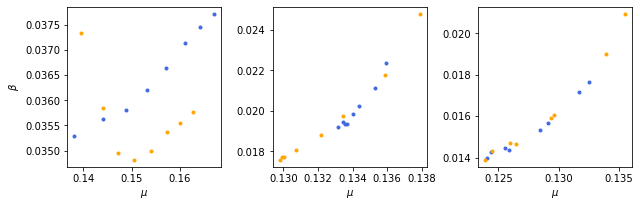

In [200]:
#plot_orders(mle_params, mm_params, 'test')
plot_mu_beta_lr(mle_params, mm_params, 'test')

In [210]:
params = plot_top_models(tevs, mle_params, mm_params, 'test')

0, 'MLE'
0.11382765531062125 0.032537114292557304 0.7995991983967935
1, 'MM'
0.12925851703406815 0.01769506502838769 0.6653306613226453
2, 'MM'
0.12925851703406815 0.014307754265976734 0.6472945891783567
Error in callback <function flush_figures at 0x7fc65abe7d30> (for post_execute):


KeyboardInterrupt: 

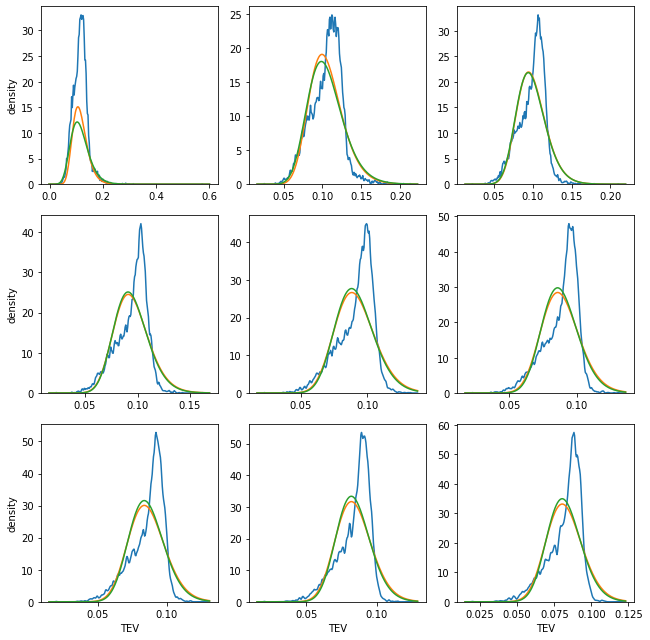

In [155]:
plot_lower_orders(tevs, mle_params, mm_params, 0, "test")

LinregressResult(slope=-0.0589019223106555, intercept=0.04245573182350335, rvalue=-0.6609964369431286, pvalue=0.10596616984048866, stderr=0.029904175290733657, intercept_stderr=0.0037971641445783497)

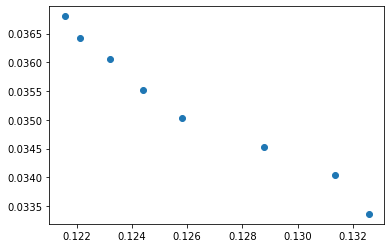

In [564]:
plt.scatter(mle_params[2][0][2:], mle_params[0][1][2:])
st.linregress(mm_params[2][0][3:], mm_params[0][1][3:])

In [199]:
def shift(arr, idx):
    return np.sign(arr[idx] - arr[idx+1])

def find_pi(ax, data, mu, beta, plot=True):
    axes, kde = FFTKDE(bw=0.0005, kernel='gaussian').fit(data).evaluate(2**8)
    kde = kde/auc(axes, kde)
    trunk = len(axes[axes < 0.15])
    axes_t = axes[:trunk]
    kde_t = kde[:trunk]
    theory = lows.pdf_mubeta(axes, mu, beta, 0)
    theory_t = theory[:trunk]
    error = 1000
    best_pi = 0
    
    for pi in np.linspace(0, 1, 500):
        new_error = abs(auc(axes_t, kde_t) - auc(axes_t, pi*theory_t))
        if new_error < error:
            best_pi = pi
            error = new_error
            
        
    if plot:
        
        ax.fill_between(axes, kde, alpha=0.2, color='green')
        ax.plot(axes, kde, color='green')
        ax.plot(axes, best_pi*theory, color='red', linestyle='-')
        
        ax.set_xlim(0.0, 0.6)
        ax.set_ylim(0,)
        ax.set_xlabel("TEV")
        ax.set_ylabel("density")

    return best_pi


def plot_top_models(tevs, mle_params, mm_params, outname):
    
    fig, ax = plt.subplots(1,3,figsize=(9, 3))
    params = np.zeros((10,2))
    
    for order in range(3):
        top_hit = tevs[order][:,0]
        if mle_params[order][2].rvalue > 0.99 and np.mean(list(map(lambda x: shift(mle_params[order][0], x), range(9)))) < 0:
            print(f"{order}, 'MLE'")
            best_mu, best_beta = qq_lr(top_hit, mle_params[order][2])
        else:
            """
            mm_lr = st.linregress(mm_params[order][0][3:], mm_params[order][1][3:])
            print(mm_lr)
            if abs(mm_lr.rvalue) >= 0.99:
                print("MM LR")
                best_mu, best_beta = qq_lr(top_hit, mm_lr)
            if abs(mm_lr.rvalue) < 0.99:"""
            print(f"{order}, 'MM'")
            best_mu, best_beta = qq_mean(top_hit, 'test', np.mean(mm_params[order][1][-3:]))
                
        best_pi = find_pi(ax[order], top_hit, best_mu, best_beta)
        params[order+2,:] = [best_mu, best_beta]
        print(best_mu, best_beta, best_pi)
        
    fig.tight_layout()
    fig.savefig(f"./graphs/{outname}.png", dpi=600, bbox_inches="tight")
    return params

def plot_lower_orders(tevs, mle_params, mm_params, charge, outname):
      
    fig, ax = plt.subplots(3,3, figsize=(9,9))
    sss =1
    for row in range(3):
        for col in range(3):
            axes, kde = FFTKDE(bw=0.0005, kernel='gaussian').fit(tevs[charge][:,sss]).evaluate(2**8)
            ax[row%3, col].plot(axes, kde)
            
            mle_kde = lows.pdf_mubeta(axes, mle_params[charge][0][sss], mle_params[charge][1][sss], sss)
            ax[row%3, col].plot(axes, mle_kde)
            
            mm_kde = lows.pdf_mubeta(axes, mm_params[charge][0][sss], mm_params[charge][1][sss], sss)
            ax[row%3, col].plot(axes, mm_kde)
            
            ax[row%3, col].set_ylim(0,)
            
            if col == 0:
                ax[row%3, col].set_ylabel("density")
            if row == 2:
                ax[row%3, col].set_xlabel("TEV")
                
            #ax[row%3, col].set_xlim(0, 0.4)
            sss += 1
            
    fig.tight_layout()
    fig.savefig(f"./graphs/{outname}.png", dpi=600, bbox_inches="tight")
    
    
def scatter_params(params, outname="example"):
    
    x=3
    fig, ax = plt.subplots(figsize=(5,5))

    for i in range(len(params)):
        ax.scatter(params[i][0][x:], params[i][1][x:])
    
    ax.set_xlabel("mu")
    ax.set_ylabel("beta")
    ax.set_title("testing")
    ax.legend(['2+', '3+', '4+'])
    #fig.savefig(f'{outname}_params_scatter.png', dpi=400, bbox_inches='tight')
    

def plot_lower_hist(tev, params, alpha):
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    sss =1
    for row in range(3):
        for col in range(3):
            plot_fit(ax[row%3, col], tev[alpha][:,sss], params[alpha][0][sss], params[alpha][1][sss], sss, col='blue', frac=1, bins=500)
            sss += 1
    #fig.savefig('yeast_3Da_1Da_f_lowerhits.png', dpi=400, bbox_inches='tight')
    
    
    
def plot_orders(mle_params, mm_params, outname):
    no_orders = 10
    fig, ax = plt.subplots(2,3, figsize=(9,4.5))
  
    for row in range(2):
        for col in range(3):
            ax[row, col].scatter(np.arange(no_orders)+1, mle_params[col][row], marker='.')
            ax[row, col].scatter(np.arange(no_orders)+1, mm_params[col][row], marker='.')
            ax[row, col].set_xticks(np.arange(10)+1)
            if row == 0:
                ax[row, col].set_ylabel(r"$\mu$")
            else:
                ax[row, col].set_ylabel(r"$\beta$")
            
            if row == 1:
                ax[row, col].set_xlabel("order")
    
    
    fig.tight_layout()
    fig.savefig(f"./graphs/{outname}.png", dpi=400, bbox_inches="tight")
    
    
def plot_mu_beta_lr(mle_params, mm_params, outname):
    
    no_orders = 10
    fig, ax = plt.subplots(1,3, figsize=(9,3))
    offset = 2
    
    for col in range(3):
        
        ax[col].scatter(mle_params[col][0][offset:], mle_params[col][1][offset:], marker='.', color='royalblue')
        
        #for x in range(len(mle_params[col][0][offset:])):
        #    ax[col].annotate(x+offset+1, (mle_params[col][0][offset:][x]-0.001, mle_params[col][1][offset:][x]-0.001), color='royalblue')
            
        ax[col].scatter(mm_params[col][0][2:], mm_params[col][1][2:], marker='.', color='orange')
        
        #for x in range(len(mm_params[col][0][offset:])):
        #    ax[col].annotate(x+offset+1, (mm_params[col][0][offset:][x]-0.001, mm_params[col][1][offset:][x]-0.001), color='orange')

        if col == 0:
            ax[col].set_ylabel(r"$\beta$")
            ax[col].set_xlabel(r"$\mu$")
        else:
            ax[col].set_xlabel(r"$\mu$")
    
    
    fig.tight_layout()
    fig.savefig(f"./graphs/{outname}.png", dpi=400, bbox_inches="tight")
    
    
    
#input: pepxml files, output: np arrays (TEV score, charge, N)

def parse_pepxmls(paths):

    tev = deque()
    charges = deque()
    big_n  = deque()

    for path in paths:
        print(path)
        cur_file = pepxml.read(path)

        for spec in cur_file:
            if 'search_hit' in spec.keys():
                if 'DECOY' in spec['search_hit'][0]['proteins'][0]['protein']: continue
                if len(spec['search_hit']) == 10:
                    tev.append(list(map(lambda x: -0.02*np.log(spec['search_hit'][x]['search_score']['expect']/1000), np.arange(10))))
                    charges.append(int(spec['assumed_charge']))
                    big_n.append(int(spec['search_hit'][0]['num_matched_peptides']))

    return tev, charges, big_n

#get only tevs of selected charge

def filter_charge(tev, charges, big_n, ch):
    t = np.array(tev)
    c = np.array(charges)
    n = np.array(big_n)
    mask = np.where((c == ch))
    return t[mask], n[mask]


#1 objective 1: estimate parameters for each hit separately, then plot the linear regression
def lower_params(arr):
    n0 = []
    a = []

    for hit in range(10):
        #if hit == 0: continue
        #print(hit)
        cur_tev = arr[:,hit].astype('float128')
        cur_tev = sorted(cur_tev)
        length = len(cur_tev)
        #cur_tev = cur_tev[int(length*0.05):int(length*0.95)]
        cur_n0, cur_a = lows.mle_new(cur_tev, hit)
        n0.append(cur_n0)
        a.append(cur_a)
    return n0, a

def plot_fitted( arr, N0, a, alpha, col='blue', frac=1, bins=500):
    sorted_arr = np.array(sorted(arr))
    l_lim = sorted_arr[0]
    u_lim = sorted_arr[-1]
    pdf = lows.pdf_mubeta(sorted_arr, N0, a, alpha)
    plt.plot(sorted_arr, frac*pdf,color=col)
    sns.distplot(sorted_arr, bins = np.linspace(0, 0.8, bins), kde=False, norm_hist=True,
                hist_kws=dict(histtype='step', linewidth=1, color='black'))
    #ax.set_xlim(l_lim, u_lim)
    plt.xlim(l_lim, u_lim)
    
    

def plot_fit(ax, arr, N0, a, alpha, col='blue', frac=1, bins=500):
    sorted_arr = np.array(sorted(arr))
    l_lim = sorted_arr[0]
    u_lim = sorted_arr[-1]
    pdf = lows.pdf_mubeta(sorted_arr, N0, a, alpha)
    ax.plot(sorted_arr, frac*pdf,color=col)
    ax.hist(sorted_arr, bins = np.linspace(0, 0.8, bins), histtype='step', density=True)
    median = np.median(sorted_arr)
    ax.vlines(x=median, ymin=0, ymax=20)
    #ax.set_xlim(l_lim, u_lim)
    ax.set_xlim(0, 0.3)

def plot_params(n0, a, outname = "", xxx=0):

    trim_n0 = list(n0)
    trim_a = list(a)
    linreg = st.linregress(trim_n0, trim_a)
    print(linreg)

    fig = plt.figure(figsize=(5,5))
    plt.scatter(trim_n0, trim_a, marker='o', color='royalblue')
    plt.plot([min(trim_n0), max(trim_n0)], 
                [min(trim_n0)*linreg.slope + linreg.intercept, 
                max(trim_n0)*linreg.slope + linreg.intercept], color='grey')
    plt.xlabel('mu')
    plt.ylabel("beta")
    plt.xlim(min(trim_n0)-0.001, max(trim_n0)+0.001)
    
    for x in range(len(trim_n0)):
        plt.annotate(x+xxx, (trim_n0[x]+0.00001, trim_a[x]+0.00003))
        
    #plt.hlines(xmin=min(trim_n0)-0.0001, xmax=max(trim_n0)+0.0001, y=0.02, linestyles='--')

    if outname != "":
        fig.savefig(f'./graphs/{outname}.png', bbox_inches='tight', dpi=400)
        

def get_params(tevs):
    n0, a = lower_params(tevs)
    trim_n0 = list(n0)[3:]
    trim_a = list(a)[3:]
    linreg = st.linregress(trim_n0, trim_a)

    return n0, a, linreg


def get_mm(tev):
    m1 = []
    m2 = []
    for i in range(10):
        cur_m1, cur_m2 = lows.mm_estimator(tev[:,i], i)
        m1.append(cur_m1)
        m2.append(cur_m2)
    return m1, m2


def qq_mean(tev, outname, opt_a):
    
    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    emps_df[2] = emps_df[1]/len(emps)

    errors = []
    qq_range = np.linspace(0.05, 0.4, 500)

    for i in qq_range:
    
        cur_a = opt_a
        theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], i, cur_a)
        
        diffs = theor_q - emps_df[0].to_numpy()[:-1]
        length = len(emps_df[2][emps_df[2] < 0.2])

        diffs = abs(np.sum(diffs[:length]))
        diffs = diffs/len(theor_q[:length])
        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_N0 = qq_range[opt_idx]
    
    return opt_N0, opt_a

# generate quantiles
def qq_lr(tev, linreg, outname="test"):

    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    emps_df[2] = emps_df[1]/len(emps)

    #quantile optimization
    errors = []
    qq_range = np.linspace(0.05, 0.4, 500)
    #opt_a = np.mean(mms[:,1][-3:])
    for i in qq_range:
        cur_a = i*linreg.slope + linreg.intercept
        #cur_a = opt_a
        theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], i, cur_a)
        diffs = abs(theor_q - emps_df[0].to_numpy()[:-1])

        length = len(emps_df[2][emps_df[2] < 0.1])
        
        diffs = np.sum(diffs[:length])
        diffs = diffs/len(theor_q[:length])

        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_N0 = qq_range[opt_idx]
    opt_a = opt_N0*linreg.slope + linreg.intercept
    
    fig = plt.figure(figsize=(6,6))
    plt.semilogy(qq_range, errors)
    plt.scatter(qq_range, errors, s=1)
    #plt.xlim(60,70)
    plt.xlabel("N0")
    plt.ylabel("loss")
    plt.savefig(f"./graphs/1{outname}.png", dpi=600, bbox_inches='tight')

    theor_q = lows.gumbel_ppf(emps_df[2].to_numpy()[:-1], opt_N0, opt_a)
    emps_q = emps_df[0].to_numpy()[:-1]

    fig1 = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k')
    plt.scatter(theor_q, emps_q, s=3)

    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.xlabel("theoretical quantile")
    plt.ylabel('empirical quantile')
    plt.savefig(f"./graphs/2{outname}.png", dpi=600, bbox_inches='tight')
    
   
    return opt_N0, opt_a


            

In [259]:
emps = sorted(tevs[0][:,0])
emps_df = pd.DataFrame(emps)

In [263]:
emps_df[1] = emps_df.index + 1
emps_df[2] = emps_df[1]/len(emps)

In [264]:
emps_df

,0,1,2
0,0.025317,1,0.000158
1,0.040499,2,0.000317
2,0.042741,3,0.000475
3,0.045461,4,0.000634
4,0.048181,5,0.000792
...,...,...,...
6305,0.600802,6306,0.999366
6306,0.611751,6307,0.999525
6307,0.613944,6308,0.999683
6308,0.656142,6309,0.999842


In [275]:
def qq_lr(tev, linreg):
    
        emps = sorted(tev)
        emps_df = pd.DataFrame(emps)
        emps_df[1] = emps_df.index + 1
        
        #empirical cdf
        emps_df[2] = emps_df[1]/len(emps)

        #quantile optimization
        errors = []
        qq_range = np.linspace(0.05, 0.4, 500)
        #opt_a = np.mean(mms[:,1][-3:])
        for i in qq_range:
            cur_a = i*linreg.slope + linreg.intercept
            #cur_a = opt_a
            theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], i, cur_a)
            diffs = abs(theor_q - emps_df[0].to_numpy()[:-1])

            length = len(emps_df[0][emps_df[0] < 0.2])
            
            diffs = np.sum(diffs[:length])
            diffs = diffs/len(theor_q[:length])

            errors.append(diffs)

        opt_idx = errors.index(min(errors))
        opt_N0 = qq_range[opt_idx]
        opt_a = opt_N0*linreg.slope + linreg.intercept
        
        fig = plt.figure(figsize=(6,6))
        plt.semilogy(qq_range, errors)
        plt.scatter(qq_range, errors, s=1)
        #plt.xlim(60,70)
        plt.xlabel("N0")
        plt.ylabel("loss")
        #plt.savefig(f"./graphs/{self.out}_optim_loss.png", dpi=600, bbox_inches='tight')

        theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], opt_N0, opt_a)
        emps_q = emps_df[0].to_numpy()[:-1]
        
        fig1 = plt.figure(figsize=(6,6))
        plt.plot([0, 1], [0, 1], color='k')
        plt.scatter(emps_q, theor_q, s=3)

        plt.xlim(0, 0.2)
        plt.ylim(0, 0.2)
        plt.xlabel("theoretical quantile")
        plt.ylabel('empirical quantile')
        #plt.savefig(f"./graphs/{self.out}_optim_QQ.png", dpi=600, bbox_inches='tight')
        
    
        return opt_N0, opt_a

In [285]:
def qq_mean(tev, opt_beta):
    
    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    #empirical cdf
    emps_df[2] = emps_df[1]/len(emps)

    errors = []
    qq_range = np.linspace(0.05, 0.4, 500)

    for i in qq_range:

        theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], i, opt_beta)
        
        diffs = theor_q - emps_df[0].to_numpy()[:-1]
        length = len(emps_df[0][emps_df[0] < 0.2])

        diffs = abs(np.sum(diffs[:length]))
        diffs = diffs/len(theor_q[:length])
        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_mu = qq_range[opt_idx]
    
    fig = plt.figure(figsize=(6,6))
    plt.semilogy(qq_range, errors)
    plt.scatter(qq_range, errors, s=1)
    #plt.xlim(60,70)
    plt.xlabel("N0")
    plt.ylabel("loss")
    #plt.savefig(f"./graphs/{self.out}_optim_loss.png", dpi=600, bbox_inches='tight')

    theor_q = lows.gumbel_new_ppf(emps_df[2].to_numpy()[:-1], opt_mu, opt_beta)
    emps_q = emps_df[0].to_numpy()[:-1]
    
    fig1 = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k')
    plt.scatter(emps_q, theor_q, s=3)

    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.xlabel("theoretical quantile")
    plt.ylabel('empirical quantile')
    #plt.savefig(f"./graphs/{self.out}_optim_QQ.png", dpi=600, bbox_inches='tight')
    
    return opt_mu, opt_beta

In [287]:
df['tev'].cumsum()

0           0.152751
1           0.253749
2           0.364329
3           0.489025
4           0.748332
            ...     
15151    2476.550553
15152    2476.832643
15153    2476.966018
15154    2477.055501
15155    2477.370850
Name: tev, Length: 15156, dtype: float64

In [290]:
df

,pv,label,charge,tev
0,0.235779,2.0,2.0,0.152751
1,0.746135,2.0,2.0,0.100998
2,0.637241,4.0,2.0,0.110580
3,0.696631,2.0,3.0,0.124696
4,0.009354,1.0,2.0,0.259307
...,...,...,...,...
15151,0.000475,1.0,2.0,0.354155
15152,0.004577,1.0,2.0,0.282091
15153,0.520461,4.0,3.0,0.133375
15154,0.860518,4.0,2.0,0.089483


(0.12364729458917836, 0.037431363635926)

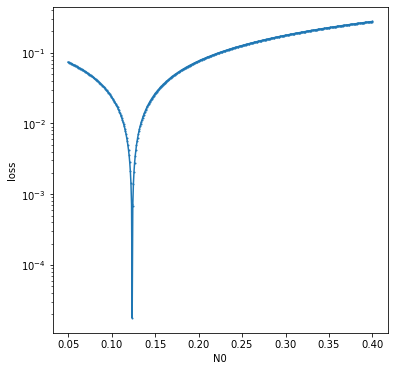

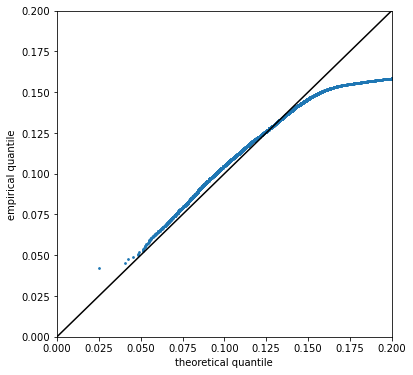

In [284]:
qq_mean(tevs[0][:,0], np.mean(mle_params[0][1][-3:]))

In [68]:
def validation_df(pepxml_file, ref_dict, params):
    
    d = pepxml.read(pepxml_file)
    ref_p = pickle.load(open(ref_dict, "rb"))
    
    #IDs = np.zeros(len(d))
    pvs = -1*np.ones(len(d))
    labels = np.zeros(len(d))
    charges = np.zeros(len(d))
    tevss = np.zeros(len(d))
    k=0
    for el in d:
        
        if 'search_hit' in el.keys():

            scanid = int(el['start_scan'])
            tev = -0.02 * np.log((el['search_hit'][0]['search_score']['expect']) / 1000)
            charge = int(el['assumed_charge'])
            
            if params[charge][0] == 0:
                p_v = 1
            else:
                p_v = 1 - lows.mubeta_cdf(tev, params[charge][0], params[charge][1])

            pep = el['search_hit'][0]['peptide']
            new_seq = pep.replace('I', 'X').replace('L', 'X')
            label = 0
            
            
            if scanid in ref_p.keys():
                if ref_p[scanid] == new_seq:
                    label = 1
                else:
                    label = 0
            if scanid not in ref_p.keys():
                label = 2
                
            #if "random" in el['spectrum']:
            #    label = 3

            if 'DECOY' in el['search_hit'][0]['proteins'][0]['protein']:
                label = 4
                    
            pvs[k] = p_v
            labels[k] = label
            charges[k] = charge
            tevss[k] = tev
            k += 1
            
    df = pd.DataFrame(np.array([pvs, labels, charges, tevss]).T)
    df.columns = ['pv', 'label', 'charge', 'tev']
    df = df[df['pv'] != -1]       
    
    return df

def BH(df, bh, pv_name='pv'):
    #df = df[(df["label"] == 1) | (df["label"] == 2)]
    
    df.loc[:,'bh'] = bh.values
    finaldf = df[df[pv_name] <= df['bh']]
    
    return finaldf


#generate bootstrapped fdp estimates
#get subsample from df and calculate the stats for it, accumulate the stats 

def bootstrap_fdr(df, ch, reps, colname='pv'):
    
    work_df = df[df["charge"] == ch]
    length = np.arange(len(work_df))
    
    fdps = np.zeros((reps, 100))
    tps = np.zeros((reps,100))
    
    for rep in range(reps):
        print(rep)
        random.seed()
        new_sel = random.choices(length, k=len(length))
        #print(new_sel)
        new_df = work_df.iloc[new_sel, :]
        fdr, fdp, tp = fdr_lower(new_df, ch, 0.1, colname=colname)
        fdps[rep, :] = fdp
        tps[rep,:] = tp
    
    return fdps, tps

data_lower4 = bootstrap_fdr(df, 4, 200)

dec_2 = get_decoy_pvs(df, 4)
data_dec4 = bootstrap_fdr(dec_2, 4, 200)
    
    
    
    

    

0
1
2
3
4
5


KeyboardInterrupt: 

In [125]:
new_ch4 = bootstrap_fdr(ch4, 4, 200, 'pv_em')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [126]:
fdp_stats_em = val_stats(new_ch4, 0.32)

In [225]:
for pos, idx in enumerate(ch4.index):
    print(pos)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

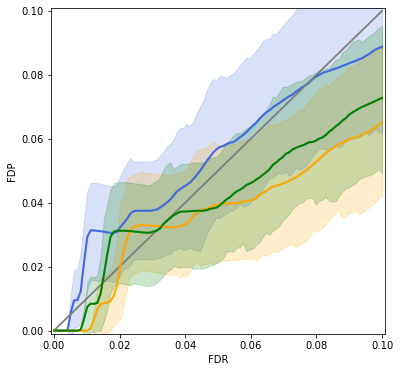

In [219]:
fig, ax = plt.subplots(figsize=(6,6))
plot_stats(ax, fdrs, fdp_stats_low4[0], 'royalblue', xy=1)
plot_stats(ax, fdrs, fdp_stats_em[0], 'orange', xy=1)
plot_stats(ax, fdrs, fdp_stats_dec4[0], 'green')
#fig.savefig("./graphs/all_test.png", dpi=600)

In [124]:
ch4 = df[df['charge'] == 4]
ch4 = add_pvs(ch4, p)

In [62]:
def add_pvs(df, params):

    pvs = 1- lows.mubeta_cdf(df['tev'].values, params[0], params[1])
    df['pv_em'] = pvs
    return df

0.09707224039321563
0.12181750886319852 0.05272661369350286 0.15783791554859475 0.09086720367338255 0.713221381897667
0.10312948155554665 0.023550471827396335 0.2619890274208747 0.10871797114480249 0.7581852999417845
0.11818964514208644 0.0477849413758793 0.17813824983744467 0.09694051090569451 0.7474175838044071
0.10434537102148074 0.025181572433839963 0.2749675550053392 0.10823949930992563 0.7743376032067377
0.11350853228981977 0.04034629784827936 0.2163563076804029 0.11463161746044635 0.7660679485898937
0.10471321728285361 0.026019626453283637 0.28445899292154436 0.10559843663045947 0.7775178591563392
0.10839071613809946 0.031607255656458166 0.26309518955515465 0.1212053934345265 0.775506786902596
0.10482040157342269 0.026436004438459785 0.29014457219558154 0.10323048881910303 0.7802040698393746
0.106097241182011 0.028137606103372147 0.2840621607451249 0.11061761041919722 0.7811916384859117
0.10487568647013273 0.026666769651461822 0.2938835303957222 0.10142271255186303 0.78218151653

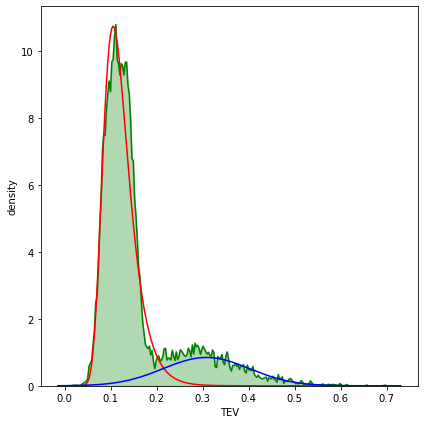

In [209]:
c = 2
p = ems.em_algorithm(df[df['charge'] ==c]['tev'].to_numpy(), 0.1, 0.02, 0.2, 0.5)
print(p)
ems.plot_em(df[df['charge'] == c]['tev'].values, p, 'testing')

In [130]:
def get_cis(data, idx, alpha):
    
    master_mean = np.mean(data[:,idx])

    diff = sorted([el - master_mean for el in data[:,idx]])
   
    ci_u = master_mean - diff[int(len(diff)*alpha/2)]
    ci_l = master_mean - diff[int(len(diff)*(1- alpha/2))]
    
    return master_mean, ci_l, ci_u


def val_stats(data, alpha):

    fdp_stats = np.zeros((3, 100))
    tp_stats = np.zeros((3,100))


    for i in range(100):
        
        fdp_stats[:,i] = get_cis(data[0], i, alpha)
        tp_stats[:,i] = get_cis(data[1], i, alpha)
    
    return fdp_stats, tp_stats

def plot_stats(ax, fdrs, fdp_stats, col, xy=False):
    fdrs = np.linspace(0.0001, 0.1, 100)
    
    if xy: ax.plot([0.0001,0.1], [0.0001, 0.1], c='gray')
    
    ax.plot(fdrs, fdp_stats[0,:], color=col, linewidth=2)
    
    ax.fill_between(fdrs, fdp_stats[0,:], fdp_stats[2,:], alpha=0.2, color=col)
    ax.fill_between(fdrs, fdp_stats[0,:], fdp_stats[1,:], alpha=0.2, color=col)
    
    #ax.plot(fdrs, fdp_stats[2,:], alpha=0.5, color=col, linestyle='-', linewidth=1)
    #ax.plot(fdrs, fdp_stats[1,:], alpha=0.5, color=col, linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.001, 0.1+0.001)
    ax.set_ylim(-0.001, 0.1+0.001)
    ax.set_xlabel("FDR")
    ax.set_ylabel("FDP")


In [35]:
fdp_stats_low4 = val_stats(data_lower4, 0.32)
fdp_stats_dec4 = val_stats(data_dec4, 0.32)

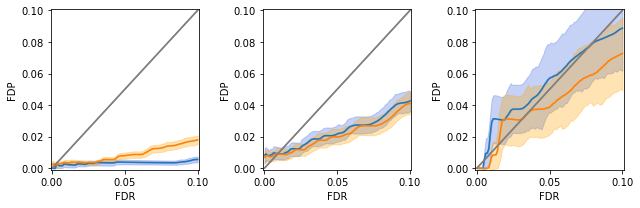

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(9,3))
#ax2 = ax.twinx()
fdrs = np.linspace(0.0001, 0.1, 100)
plot_stats(ax[0], fdrs, fdp_stats_low[0], 'royalblue')
plot_stats(ax[0], fdrs, fdp_stats_dec[0], 'orange')
plot_stats(ax[1], fdrs, fdp_stats_low3[0], 'royalblue')
plot_stats(ax[1], fdrs, fdp_stats_dec3[0], 'orange')
plot_stats(ax[2], fdrs, fdp_stats_low4[0], 'royalblue')
plot_stats(ax[2], fdrs, fdp_stats_dec4[0], 'orange')
#plot_stats(ax2, fdrs, fdp_stats_low[1], 'blue')
#plot_stats(ax2, fdrs, fdp_stats_dec[1], 'blue')
fig.tight_layout()
fig.savefig("./graphs/fdr_ci_adultf16.png", dpi=600, bbox_inches='tight')




In [67]:
def get_decoy_pvs(df, ch):
    
    df = df[df.charge == ch]
    
    dec_mu, dec_beta = lows.mle_new(df[df["label"] == 4]['tev'].values, 0)
    dec_pv = []
    
    for i in df.index:
        cur_tev = df.loc[i, 'tev']
        cur_pv = 1-lows.mubeta_cdf(cur_tev, dec_mu, dec_beta)
        dec_pv.append(cur_pv)
        
    df['pv'] = dec_pv
    
    return df

def fdr_lower(df, ch, lim, plot=True, colname='pv'):
    fdps = []
    fdrs = np.linspace(0.0005, 0.1, 100)
    #decs = []
    tps = []
    
    df = df[(df["label"] != 4) & (df["charge"] == ch)]
    
    df.sort_values("pv", ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.index += 1
    

    for fdr in fdrs:
        
        bh = pd.Series((df.index.to_series() * fdr) / len(df))
        
        adj = BH(df, bh, colname)
        alls = len(adj)
        fdp = 1-len(adj[adj['label'] == 1])/alls
        #dec = 2*len(ch3[ch3['label'] == 4])/len(ch3)
        tp = len(adj[adj.label == 1])/len(df[df.label==1])
        
        
        tps.append(tp)
        fdps.append(fdp)
        #decs.append(dec)
        
    #if plot==True: plot_val_results(ax, fdrs, fdps, tps, lim, 'royalblue', 'orange')
        
    return fdrs, fdps, tps
        
def plot_val_results(ax, fdrs, fdps, tps, lim, col1, col2):
    
    #fig, ax = plt.subplots(figsize=(6,6))
    #lim = 0.1
    ax.grid(color='gray', linestyle='--', linewidth=1, alpha=0.2)
    ax.plot(fdrs, fdps, color=col1)
    ax.scatter(fdrs, fdps, marker='.', color=col1)
    ax.set_ylabel("FDP")
    ax2=ax.twinx()
    #ax.plot(fdr, decs)
    #ax.scatter(fdr, decs, marker='.')
    ax2.plot(fdrs, tps, marker='.', color=col2)
    ax2.set_ylabel("TPR", color=col2)
    ax2.set_ylim(0,1)
    ax.plot([0,lim], [0,lim], color='k', alpha=0.5)
    ax.set_xlim(-0.001, lim)
    ax.set_ylim(-0.001, lim)
    #ax2.legend(['lower', 'decoys', 'x-y'])
    
    
def fdr_dec(df, ch):
    fdp = []
    fdrs = []
    decs = []
    peps_low = []
    peps_decs = []
    tps = []
    df = df[df.charge==ch]
    df.sort_values("tev", ascending=False, inplace=True)

    for i in np.linspace(1, len(df), 1000):
        if i == 0: continue
        ch3 = df.iloc[:int(i), :]
        c = 1-len(ch3[ch3['label'] == 1])/len(ch3)
        dec = 2*len(ch3[ch3['label'] == 4])/len(ch3)
        tp = len(ch3[ch3.label == 1])/len(df[df.label==1])
        tps.append(tp)
        fdp.append(c)
        fdrs.append(dec)
        
    fig, ax = plt.subplots(figsize=(6,6))
    lim = 0.1
    ax.grid(color='gray', linestyle='--', linewidth=1, alpha=0.2)
    ax.plot(fdrs, fdp, color='royalblue')
    ax.scatter(fdrs, fdp, marker='.', color='royalblue')
    ax.set_ylabel("FDP", color='royalblue')
    ax2=ax.twinx()
    #ax.plot(fdr, decs)
    #ax.scatter(fdr, decs, marker='.')
    ax2.plot(fdrs, tps, color='orange')
    ax2.set_ylabel("TPR", color='orange')
    ax2.set_ylim(0,1)
    ax.plot([0,lim], [0,lim], color='k', alpha=0.5)
    ax.set_xlim(-0.001, lim)
    ax.set_ylim(-0.001, lim)
    #ax2.legend(['lower', 'decoys', 'x-y'])
    return fdr, fdp, tps
    
    

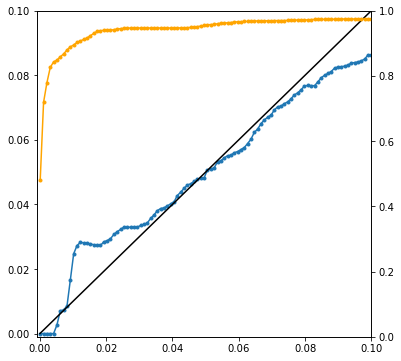

In [140]:
fig, ax = plt.subplots(figsize=(6,6))
fdrs = np.linspace(0.0001, 0.1, 100)
#for i in range(10):
ax.plot(fdrs, np.mean(test[0], axis=0), marker='.')
ax.set_xlim(-0.001, 0.1)
ax.set_ylim(-0.001,0.1)
ax2=ax.twinx()
ax2.plot(fdrs, np.mean(test[1], axis=0), marker='.', color='orange')
ax2.set_ylim(0,1)
ax.plot([0,0.1],[0.,0.1], c='k')

In [11]:
ref_dict = '/data/dominik/lower_order/validation/Adult_Heart_Gel_Elite_54_f16.pkl'
pepxml_file = '/data/dominik/lower_order/validation/refined_Adult_Heart_Gel_Elite_54_f16.mzXML_td.pep.xml'

df = validation_df(pepxml_file, ref_dict, params)

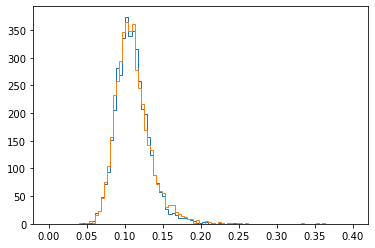

In [565]:
bb = np.linspace(0, 0.4, 100)
plt.hist(ch4[ch4.label==4].tev, bins=bb, histtype='step')
plt.hist(ch4[ch4.label==2].tev, bins=bb, histtype='step')
plt.show()

/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tev', ylabel='Density'>

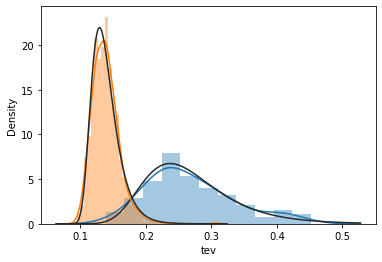

In [547]:
sns.distplot(df[(df.charge == 4) & (df.label == 1)]['tev'], fit=st.gumbel_r)
sns.distplot(df[(df.charge == 4) & (df.label != 1)]['tev'], fit=st.gumbel_r)

In [422]:
ch = 2
data = df[df["label"] == 4]
axes, kde = FFTKDE(bw=0.0005, kernel='gaussian').fit(data['tev'].values).evaluate(2**8)
kde1 = lows.pdf_mubeta(axes, params[ch][0], params[ch][1],0)

(0.0, 0.6)

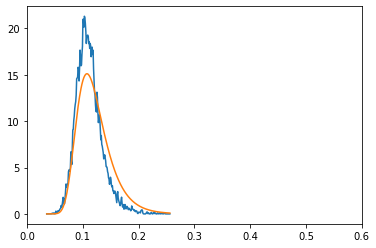

In [423]:
plt.plot(axes, 1*kde)
plt.plot(axes, kde1)
plt.xlim(0, 0.6)